In [545]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [546]:
# In[2]:


mu = 0  #MeV, Chemical Potential
T = 15  #MeV, Temperature
kappa = 1 #Constant

q = 0
ui = 1e-4
uf = 1-(1e-5)
ucount = 1000

wi = 700
wf = 1800
#wcount = 800
wcount = 111
wresolution = .1

In [547]:
# In[3]:


#Blackness function. Returns f(u) and f'(u) as a list
def f(u,Q):
    f = 1-((1+(Q**2))*(u**4))+((Q**2)*(u**6))
    f_p = -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    return [f,f_p]
    
#Dilaton field.
def phi(u,zh,mug):
    phi = (mug**2)*(zh**2)*(u**2)
    phi_p = 2*u*(mug**2)*(zh**2)
    return [phi,phi_p]
    
#440 MeV. The confinement scale
def mu_g():
    return 388 #440
    
#Related to black hole charge. Must return a value from 0 < Q^2 < 2
#Manually checked for mu = 0
def Q_func(zh):
    global q #Prevents function from interpretting q as a local variable
    
    if mu == 0:
        q = 0
    else:
        if q == 0:
            q = (mu**3 + kappa * np.pi * T * mu * (kappa * np.pi * T + np.sqrt((kappa * np.pi * T)**2 + 2 * mu**2))) / (2 * kappa**3)
    return mu * zh / kappa

#Black Hole Horizon. calculated from T, mu, and k
#Manually checked for mu = 0
def z_h():
    if mu == 0:
        return 1 / (np.pi * T)
    
    return ((-T * np.pi * (kappa**2)) + ((kappa**2) * np.sqrt((T**2 * np.pi**2) + (2 * mu**2 / kappa**2)))) / mu**2   

#Values of lambda 1-4
def lam_function():
    return [7.438, 0.0, -22.6/(6*(2**(1/2))), 4.2]

def calculate_variables():
    mug = mu_g()
    zh = z_h()
    Q = Q_func(zh)
    lam = lam_function()
    
    return (mug,zh,Q,lam)

In [548]:
# In[4]:


#Coefficients
def c2():
    return 1

#Manually checked w/ calculator, correct output
def c4(w,zh,mug,c_2):
    c_4 = (1/8)*(
        (4*c_2*(zh**2)*(mug**2))
        -(c_2*(zh**2)*(w**2))
    )
    return c_4

#Manually checked w/ calculator, correct output
def c6(w,zh,mug,Q,c_2,c_4):
    c_6 = (1/24)*(
        (8*c_2)
        + (8*c_2*(Q**2))
        + (8*c_4*(zh**2)*(mug**2))
        - (c_4*(zh**2)*(w**2))
    )
    return c_6

def d0():
    return 1

def d2():
    return 0

#Manually checked w/ calculator, correct output
def d(w,zh,d_0):
    return -(d_0*(zh**2)*(w**2))/(2*c2())

#Manually checked w/ calculator, correct output
def d4(w,zh,mug,d_0,d_2):
    return (1/64)*(
        (32*d_2*(zh**2)*(mug**2))
        - (8*d_2*(zh**2)*(w**2))
        + (4*d_0*(zh**4)*(mug**2)*(w**2))
        - (3*d_0*(zh**4)*(w**4))
    )

#Manually checked w/ calculator, correct output
def d6(w,zh,mug,d_0,d_2,d_4):
    return (1/4608)*(
        (1536*d_2)
        + (1536*d_2*(Q**2))
        + (1536*d_4*(zh**2)*(mug**2))
        - (448*d_0*(zh**2)*(w**2))
        - (192*d_4*(zh**2)*(w**2))
        - (448*d_0*(Q**2)*(zh**2)*(w**2))
        + (64*d_0*(zh**6)*(mug**4)*(w**2))
        - (36*d_0*(zh**6)*(mug**2)*(w**4))
        + (5*d_0*(zh**6)*(w**6))
    )

def coefficients(w,zh,mug,Q):
    c_2 = c2()
    c_4 = c4(w,zh,mug,c_2)
    c_6 = c6(w,zh,mug,Q,c_2,c_4)
    
    d_0 = d0()
    d_2 = d2()
    d_4 = d4(w,zh,mug,d_0,d_2)
    d_6 = d6(w,zh,mug,d_0,d_2,d_4)
    d_d = d(w,zh,d_0)
    
    return (c_2,c_4,c_6,d_0,d_2,d_4,d_6,d_d)

In [549]:
# In[5]:


#Scalar Field Solutions
def v1(u,cs):
    c_2,c_4,c_6 = cs
    
    v_1 = (c_2*(u**2))+(c_4*(u**4))+(c_6*(u**6))
    v_1p = (2*c_2*u)+(4*c_4*(u**3))+(6*c_6*(u**5))

    return [v_1,v_1p]

def v2(u,v,ds):
    d_0,d_2,d_4,d_6,d_d = ds
    v_2 = (d_0
        +(d_2*(u**2))
        +(d_4*(u**4))
        +(d_6*(u**6))
        +(d_d*v[0]*np.log(u)))
    
    v_2p = ((2*d_2*(u))
        +(4*d_4*(u**3))
        +(6*d_6*(u**5))
        +(d_d*((v[1]*np.log(u))+(v[0]*(1/u))))
           )
    return [v_2,v_2p]

def vs(u,w,zh,mug,Q):
    c_2,c_4,c_6,d_0,d_2,d_4,d_6,d_d = coefficients(w,zh,mug,Q)
    
    cs = (c_2,c_4,c_6)
    ds = (d_0,d_2,d_4,d_6,d_d)
    
    v_1 = v1(u,cs)
    v_2 = v2(u,v_1,ds)
    return (v_1,v_2)

In [550]:
# In[6]:


#Vector Equation of Motion; Must be solved using solve_ivp
def vector_eom(v,u,w,Q,zh,mug):
    
    fu = f(u,Q)
    phiu = phi(u,zh,mug)
    
    v1,v2 = v
    
    v1p = v2
    v2p = ((v2*(
            (1/u)-(fu[1]/fu[0])+(phiu[1])
        ))
        -(
            v1*(
                (w**2)*(zh**2)/(fu[0]**2)
            )
        ))
    
    #if(w==wi):
    #    print("u: " + str(u))
    #    print("v1: " + str(v1))
    #    print("v2: " + str(v2))
    #    print("v1p: " + str(v1p))
    #    print("v2p: " + str(v2p))
    
    return [v1p,v2p]

In [551]:
# In[7]:


#Asymptotic Solution at the Horizon
def psi_m(u,w):
    c = -complex(0,1)*w*zh/(2*(2-(Q**2)))
    
    psim = (1-u)**(c)
    psim_p = -c*((1-u)**(c-1)) #psim_p = c*((1-u)**(-c))
    
    return [psim,psim_p]

In [552]:
# In[8]:


#Ratio of B and A; 
def BA(w,Q,zh,mug):
    v_1,v_2 = vs(ui,w,zh,mug,Q)
    
    #u = np.flip(1 - np.geomspace(ui,uf,ucount))
    
    #Correct for first values of u and w
    psi1s = solve_ivp(
        lambda u, y: vector_eom(y, u, w, Q, zh, mug),
        [ui, uf],
        v_1,
        method='LSODA', # Use Runge-Kutta 45 method
        rtol=1e-8, # Relative tolerance
        atol=1e-10 # Absolute tolerance
    )
    #psi1s = odeint(vector_eom, v_1, u, args = (w,Q,zh,mug))
    psi2s = solve_ivp(
        lambda u, y: vector_eom(y, u, w, Q, zh, mug),
        [ui, uf],
        v_2,
        method='LSODA',
        rtol=1e-8, #this is the relative tolerance
        atol=1e-10 #this is the absolute tolerance
    )
    #psi2s = odeint(vector_eom, v_2, u, args = (w,Q,zh,mug))
    
    psi1 = psi1s.y[0][-1]
    #psi1 = psi1s[:,0][-1]
    if(psi1 == 0 or psi1 == float('NaN')): 
        print("psi1 " + str(psi1),flush=True)
        print("w " + str(w),flush=True)
    psi1p = psi1s.y[1][-1]
    #psi1p = psi1s[:,1][-1]
    if(psi1p == 0 or psi1p == float('NaN')): 
        print("psi1 " + str(psi1p),flush=True)
        print("w " + str(w),flush=True)
    psi2 = psi2s.y[0][-1]
    #psi2 = psi2s[:,0][-1]
    if(psi2 == 0 or psi2 == float('NaN')): 
        print("psi2 " + str(psi2),flush=True)
        print("w " + str(w),flush=True)
    
    psi2p = psi2s.y[1][-1]
    #psi2p = psi2s[:,1][-1]
    if(psi2p == 0 or psi2p == float('NaN')): 
        print("psi2p " + str(psi2p),flush=True)
        print("w " + str(w),flush=True)
        
    psim = psi_m(uf,w)
    if(psim == 0 or psim == float('NaN')): 
        print("psi2p " + str(psim),flush=True)
        print("w " + str(w),flush=True)
    
    numerator = ((psim[0]*psi2p)-(psim[1]*psi2))
    denominator = ((psim[0]*psi1p)-(psim[1]*psi1))

    try:
        B_A = (numerator/denominator)
        
    except:
        print("Error at w value: " + str(w),flush=True)
        print("psi-minus at w: " + str(psim[0]),flush=True)
        print("psi-minus-prime at w: " + str(psim[1]),flush=True)
        print("psi1 at w: " + str(psi1),flush=True)
        print("psi1-prime at w: " + str(psi1p),flush=True)
        print("psi2 at w: " + str(psi2),flush=True)
        print("psi2-prime at w: " + str(psi2p),flush=True)
        
        B_A = 0
    
    #Checked manually, B/A is correct 
    return B_A #np.imag(B_A) #np.abs(B_A) #np.real(B_A)

In [553]:
# In[9]:


#calculate the data set
def calculate_data(wi,wf,wcount,wresolution):
    
    ws = np.linspace(wi,wf,wcount)

    currentresolution = np.abs((wf-wi))/wcount
    print('Starting resolution ' + str(currentresolution))

    BAs = Parallel(n_jobs=-1)(delayed(BA)(w,Q,zh,mug) for w in ws)

    expectedPeaks = (wf/mug)**2/4
    print(f'Expected number of peaks at zero temperature: {expectedPeaks}')
    while True:
        
        peaks,_ = find_peaks(np.abs(np.imag(BAs)),prominence = 0.01,distance = 10)
        #if len(peaks) <= 1 + (((wf-wi)/mug)**2)/2 and currentresolution > wresolution:
        if len(peaks) <= expectedPeaks and currentresolution > wresolution: 
            midpoints = (ws[:-1] + ws[1:]) / 2.0
            currentresolution = currentresolution / 2.0
            print(f'Found {len(peaks)} peaks')
            print(f'Resolution updated to {currentresolution}')
            
            ws = np.insert(ws,np.arange(1,len(ws)),midpoints)
            
            newBAs = Parallel(n_jobs=-1)(delayed(BA)(w,Q,zh,mug) for w in midpoints)
            
            BAs = np.insert(BAs,np.arange(1,len(BAs)),newBAs)

            if len(ws) % 2 == 1:
                ws = np.append(ws,ws[-1] + currentresolution)
                BAs = np.append(BAs,BA(ws[-1],Q,zh,mug))
        else:
            if currentresolution > wresolution:
                for i in peaks:
                    # print(f'checking peak at position {i}')
                    print(f'checking peak at w value {ws[i]}')
                    print(f'Which is {(ws[i]/mug)**2} in dimensionless units')
                
                    wmax = ws[i] + (currentresolution)
                    wmin = ws[i] - (currentresolution)
                    count = int(np.ceil((wmax - wmin)/wresolution))
                    wset = np.linspace(wmax,wmin, count)
                    BAset = Parallel(n_jobs=-1)(delayed(BA)(w,Q,zh,mug) for w in wset)
                    ws = np.append(ws,wset)
                    BAs = np.append(BAs,BAset)
            print("peaks found: " + str(len(peaks)))
            '''
            prominencebase = 0
            previousprominence = 0.1
            newpeaks,_ = find_peaks(BAs,prominence = previousprominence,)
            while not len(newpeaks) == len(peaks):
                if len(newpeaks) < len(peaks):
                    previousprominence = (previousprominence + prominencebase)/2
                else:
                    previousprominence = previousprominence + (previousprominence + prominencebase)/2
                newpeaks,_ = find_peaks(BAs,prominence = previousprominence,width = 5)
                print(f'The current prominence is {previousprominence}')
                print(f'The current peak count is: ' + str(len(newpeaks)))
                print(f'The goal peak count is: ' + str(len(peaks)))
            peaks = newpeaks
            '''
            peakws = np.zeros(len(peaks))
            peakBAs = np.zeros(len(peaks),dtype=complex)
            for i in range(len(peaks)):
                peakws[i] = ws[peaks[i]]
                peakBAs[i] = BAs[peaks[i]]
            break
    
    return (ws,BAs,peakws,peakBAs)

In [554]:
# In[10]:

mug,zh,Q,lam = calculate_variables()
ws,BAs,peakws,peakBAs = calculate_data(wi,wf,wcount,wresolution)
#TODO: Put this into a function once debugging B/A is done

Starting resolution 9.90990990990991
Expected number of peaks at zero temperature: 5.380486767988097
Found 3 peaks
Resolution updated to 4.954954954954955
Found 3 peaks
Resolution updated to 2.4774774774774775
Found 3 peaks
Resolution updated to 1.2387387387387387
Found 3 peaks
Resolution updated to 0.6193693693693694
Found 5 peaks
Resolution updated to 0.3096846846846847
checking peak at w value 775.3125
Which is 3.9929155107892047 in dimensionless units
checking peak at w value 1092.8125
Which is 7.932824690165334 in dimensionless units
checking peak at w value 1329.6875
Which is 11.744532147785698 in dimensionless units
checking peak at w value 1519.375
Which is 15.334389883522427 in dimensionless units
checking peak at w value 1669.6875
Which is 18.518548382242074 in dimensionless units
checking peak at w value 1778.4375
Which is 21.009405498766142 in dimensionless units
peaks found: 6


The peaks are located at omega values of:
[ 775.3125 1092.8125 1329.6875 1519.375  1669.6875 1778.4375]
The peaks are located at dimensionless values of:
[ 3.99291551  7.93282469 11.74453215 15.33438988 18.51854838 21.0094055 ]
The spectral function values at the peaks are:
[1.97878430e-01 4.86108087e-02 1.98276004e+00 7.94498675e+04
 1.09206150e+05 2.18903586e+03]


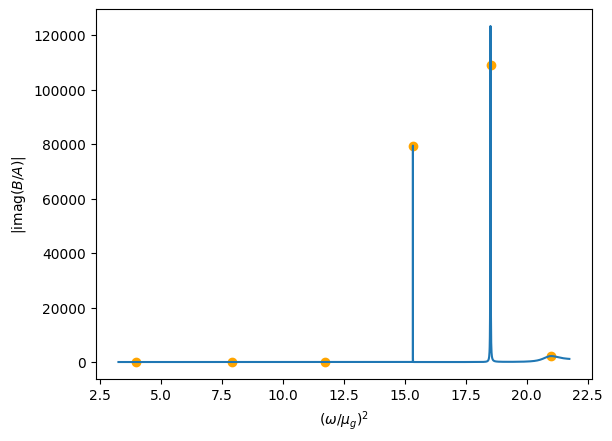

In [555]:
# Sort ws and BAs by ws in ascending order
sort_indices = np.argsort(ws)
ws_sorted = ws[sort_indices]
BAs_sorted = BAs[sort_indices]

plt.plot((ws_sorted/mug)**2,np.abs(np.imag(BAs_sorted)))
plt.xlabel("$(\omega/\mu_g)^2$")
plt.ylabel("$| \mathrm{imag}(B/A)|$")

# Also sort the peak data
peak_sort_indices = np.argsort(peakws)
peakws_sorted = peakws[peak_sort_indices]
peakBAs_sorted = peakBAs[peak_sort_indices]

#clean up the peaks data. There should not be multiple peaks within 1 MeV of each other. If there are, keep only the one associated with the largest value of np.imag(np.imag(peakBAs_sorted))
peakws_sorted = np.unique(peakws_sorted)


plt.scatter((peakws_sorted/mug)**2,np.abs(np.imag(peakBAs_sorted)),color = 'orange')

# plt.xlim(10,13)
# plt.ylim(0,6000)

print('The peaks are located at omega values of:')
print(peakws_sorted)
print('The peaks are located at dimensionless values of:')
print((peakws_sorted/mug)**2)
print('The spectral function values at the peaks are:')
print(np.abs(np.imag(peakBAs_sorted)))

plt.show()